In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import polars as pl

import pandas.api.types
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import lightgbm as lgb
import xgboost as xgb
import catboost as cb

import lifelines
from lifelines.utils import concordance_index

import sys

print(sys.version)
for i in [np, pd, pl, mpl, sns, lifelines, sklearn, lgb, xgb, cb]:
    try:
        print(i.__name__, i.__version__)
    except:
        print(i.__name__)

3.12.6 (main, Sep 30 2024, 02:19:13) [GCC 9.4.0]
numpy 1.26.4
pandas 2.2.3
polars 1.12.0
matplotlib 3.8.4
seaborn 0.13.2
lifelines 0.30.0
sklearn 1.5.2
lightgbm
xgboost 2.1.2
catboost 1.2.5


In [2]:
import dproc, sgutil, sgpp, sgml, custpp
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, KFold, ShuffleSplit, train_test_split
from sklearn.impute import SimpleImputer
from lifelines import NelsonAalenFitter

In [3]:
data_path = 'data'
model_path = 'model'

p2 =joblib.load(os.path.join(model_path, 'p2.joblib'))
df_train = p2.transform([os.path.join(data_path, 'train.csv')])

In [10]:
def score(df, prds):
    return df.groupby('race_group', observed=True).apply(
        lambda x: concordance_index(x['efs_time'], -prds.loc[x.index], x['efs']), include_groups=False
    ).pipe(
        lambda x: float(x.mean() - x.std(ddof=0))
    )

In [8]:
X_bool = ['graft_type', 'prod_type']
X_tri = [
    'arrhythmia', 'cardiac', 'diabetes', 'hepatic_mild', 'hepatic_severe',
    'in_vivo_tcd', 'melphalan_dose', 'mrd_hct', 'obesity', 'peptic_ulcer',
    'prior_tumor', 'psych_disturb', 'pulm_moderate', 'pulm_severe', 'renal_issue',
    'rheum_issue', 'rituximab', 'vent_hist'
]
X_nom = [
    'cmv_status', 'conditioning_intensity', 'cyto_score', 'cyto_score_detail', 'donor_related',
    'dri_score', 'ethnicity', 'gvhd_proph', 'prim_disease_hct', 'race_group', 'sex_match',
    'tbi_status', 'tce_div_match', 'tce_imm_match', 'tce_match'
]
X_na = [
    'arrhythmia_na', 'cardiac_na', 'diabetes_na', 'hepatic_mild_na', 'hepatic_severe_na',
    'obesity_na', 'peptic_ulcer_na', 'prior_tumor_na', 'psych_disturb_na', 'pulm_moderate_na',
    'pulm_severe_na', 'renal_issue_na', 'rheum_issue_na'
]
X_cont = ['age_at_hct', 'donor_age']
X_int = [
    'comorbidity_score', 'hla_high_res_10', 'hla_high_res_6', 'hla_high_res_8', 'hla_low_res_10',
    'hla_low_res_6', 'hla_low_res_8', 'hla_match_a_high', 'hla_match_a_low', 'hla_match_b_high',
    'hla_match_b_low', 'hla_match_drb1_low', 'hla_match_c_high', 'hla_match_c_low', 'hla_match_dqb1_high', 'hla_match_dqb1_low',
    'hla_match_drb1_high', 'hla_nmdp_6', 'karnofsky_score', 'year_hct'
]
X_all = X_tri + X_cont + X_int + X_na + X_bool + X_nom

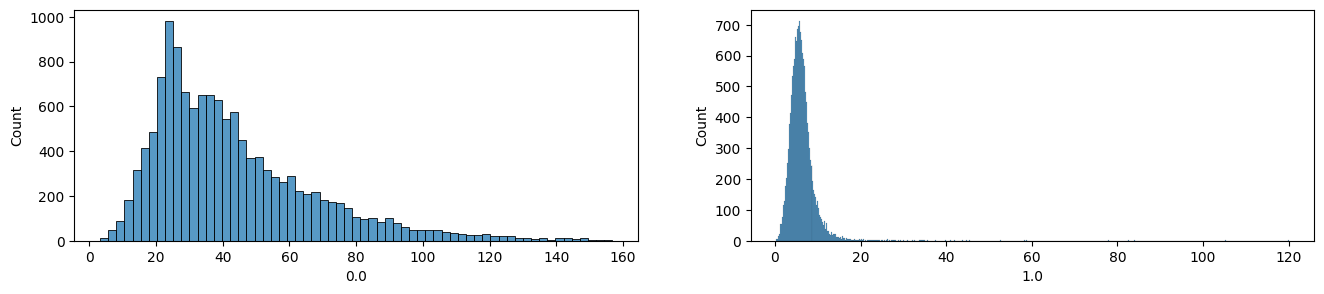

In [55]:
_, axes = plt.subplots(1, 2, figsize = (16, 3))
df_train.groupby('efs')['efs_time'].apply(
    lambda x: sns.histplot(
        x, ax = {0.0: axes[0], 1.0: axes[1]}[x.name]
    )
)
plt.show()

In [56]:
df_train0 = df_train.loc[df_train['efs'] == 0]
df_train1 = df_train.loc[df_train['efs'] == 1]

In [166]:
from sklearn.metrics import r2_score
def score(df, prds):
    return df.groupby('race_group', observed=True).apply(
        lambda x: concordance_index(x['efs_time'], -prds.loc[x.index], x['efs']), include_groups=False
    ).pipe(
        lambda x: float(x.mean() - x.std(ddof=0))
    )
def get_validation_splitter(validation_fraction):
    return lambda x: train_test_split(x, test_size = validation_fraction)

config0 = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index = df.index),
    'score_func': lambda df, prd: r2_score(df['efs_time'], prd),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'target_func': lambda df, y: y.clip(0, 80),
    'y': 'efs_time',
}

kf = KFold(n_splits=5, shuffle=True, random_state = 123)
ss = ShuffleSplit(n_splits=1, random_state = 123)
lgb_adapter = sgml.LGBMAdapter(lgb.LGBMRegressor)
xgb_adapter = sgml.XGBAdapter(xgb.XGBRegressor)
cb_adapter = sgml.CBAdapter(cb.CatBoostRegressor)

In [167]:
hparams = {
    'model_params': {'num_leaves':  15, 'n_estimators':  2500, 'colsample_bytree': 0.25, 'learning_rate': 0.02},
    'X_num': X_tri + X_cont + X_int + X_na + X_bool, 
    'X_cat': X_nom, 'cat': {'handle_unknown': 'use_encoded_value', 'unknown_value': -1},
    #'validation_fraction': 0.1
}
result = sgml.cv(df_train1, ss, hparams, config0, lgb_adapter)
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/2500 [00:00<?, ?it/s]

[0.31266328552067935]

In [163]:
(df_train0['efs_time'] > 80).mean()

0.08426288815194453

<Axes: xlabel='prd', ylabel='residual'>

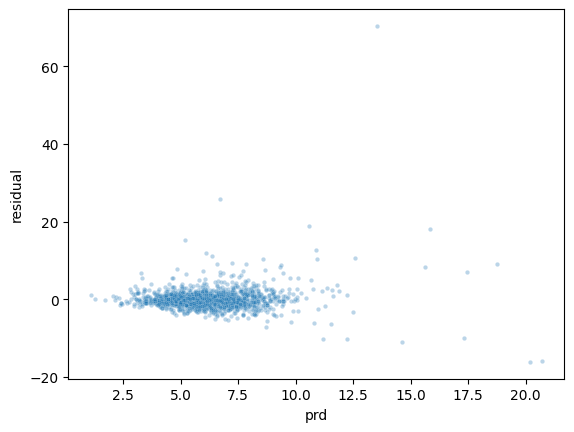

In [108]:
sns.scatterplot(
    x = result['valid_prd'].rename('prd'), y = (df_train1.loc[result['valid_prd'].index, 'efs_time'] - result['valid_prd']).rename('residual'), 
    s = 10, alpha = 0.3
)

In [152]:
config1 = {
    'predict_func': lambda m, df, X: pd.Series(m.predict(df[X]), index = df.index),
    'score_func': lambda df, prd: r2_score(df['efs_time'], prd),
    'validation_splitter': get_validation_splitter,
    'progress_callback': sgml.ProgressCallBack(), 
    'return_train_scores': True,
    'target_func': lambda df, y: y.clip(10, 160),
    'y': 'efs_time',
}

In [153]:
hparams = {
    'model_params': {'num_leaves':  15, 'n_estimators':  3500, 'colsample_bytree': 0.25, 'learning_rate': 0.02},
    'X_num': X_tri + X_cont + X_int + X_na + X_bool, 
    'X_cat': X_nom, 'cat': {'handle_unknown': 'use_encoded_value', 'unknown_value': -1},
    #'validation_fraction': 0.1
}
result = sgml.cv(df_train0, ss, hparams, config1, lgb_adapter)
result['valid_scores']

Fold:   0%|          | 0/1 [00:00<?, ?it/s]

Round:   0%|          | 0/3500 [00:00<?, ?it/s]

[0.7321043974864463]

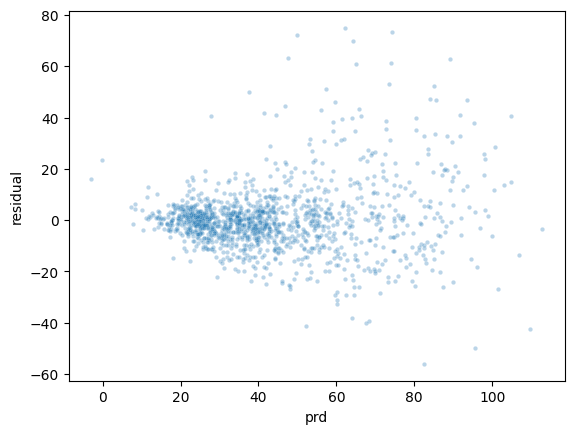

In [154]:
sns.scatterplot(
    x = result['valid_prd'].rename('prd'), y = (df_train0.loc[result['valid_prd'].index, 'efs_time'] - result['valid_prd']).rename('residual'), 
    s = 10, alpha = 0.3
)
plt.show()

In [224]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
skf = StratifiedKFold(5, random_state = 123, shuffle = True)
for train_idx, valid_idx in ss.split(df_train[X_all], df_train['efs']):
    df_cv_train, df_valid = df_train.iloc[train_idx], df_train.iloc[valid_idx]
    v_list = list()
    for q in [0.25, 0.5, 0.75, 0.95, 0.99]:
        t = df_cv_train.loc[df_cv_train['efs'] == 1.0, 'efs_time'].quantile(q)
        df_cv_train = df_cv_train.assign(efs_b = lambda x: x['efs_time'] < t)
        clf_lgb = lgb.LGBMClassifier(verbose = -1, num_leaves = 15, n_estimators = 1000, learning_rate = 0.02)
        clf_lgb.fit(df_cv_train[X_all], df_cv_train['efs_b'], categorical_feature = X_nom)
        prd1 = clf_lgb.predict_proba(df_cv_train[X_all])[:, 1]
        v_list.append(
            pd.Series(clf_lgb.predict_proba(df_valid[X_all])[:, 1], index = df_valid.index)
        )
        print(
            roc_auc_score(df_cv_train['efs'], prd1),
            roc_auc_score(df_valid['efs'], v_list[-1]),
            score(df_valid, v_list[-1])
        )

0.6098331532520053 0.5933139964672285 0.622238908104171
0.6898480429032784 0.6530690952525464 0.6499338867180077
0.7668060679820989 0.713620332111648 0.6682887063083843
0.822526077852632 0.7428804732668799 0.6474868406705969
0.8110056324328467 0.7329897829757764 0.6373878931725252


In [230]:
score(
    df_valid, 
    pd.concat(v_list, axis=1).rank().dot([0.2, 0.2, 0.3, 0.3, 0.0])
)

0.6690566939019374